In [2]:
import numpy as np 
import pandas as pd 
import os
import itertools

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input, merge, UpSampling2D, Cropping2D, ZeroPadding2D, Reshape, core, Convolution2D, Conv2DTranspose
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras import optimizers
from keras import backend as K
from keras.optimizers import SGD
from keras.layers.merge import concatenate
from keras.preprocessing.image import array_to_img
from keras.preprocessing.image import load_img

from tensorflow.python.keras.callbacks import TensorBoard

from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

import preprocess
from model_00 import get_model
import pickle
import splitdata

import keras.backend as K
import tensorflow as tf

Using TensorFlow backend.


In [3]:
with open(os.path.join(splitdata.d_data, splitdata.f_train), "rb") as file:
    files = pickle.load(file)
if not files:
    raise Exception("Could not load training files!")
print("Files: ", len(files))
print(files)

Files:  40
[('data/A04_v2/A04_01.png', 'data/A04_v2/A04_01.csv', 'data/A04_v2/A04_01.jpg'), ('data/A04_v2/A04_06.png', 'data/A04_v2/A04_06.csv', 'data/A04_v2/A04_06.jpg'), ('data/A04_v2/A04_02.png', 'data/A04_v2/A04_02.csv', 'data/A04_v2/A04_02.jpg'), ('data/A00_v2/A00_01.png', 'data/A00_v2/A00_01.csv', 'data/A00_v2/A00_01.jpg'), ('data/A02_v2/A02_09.png', 'data/A02_v2/A02_09.csv', 'data/A02_v2/A02_09.jpg'), ('data/A04_v2/A04_00.png', 'data/A04_v2/A04_00.csv', 'data/A04_v2/A04_00.jpg'), ('data/A04_v2/A04_03.png', 'data/A04_v2/A04_03.csv', 'data/A04_v2/A04_03.jpg'), ('data/A02_v2/A02_00.png', 'data/A02_v2/A02_00.csv', 'data/A02_v2/A02_00.jpg'), ('data/A03_v2/A03_01.png', 'data/A03_v2/A03_01.csv', 'data/A03_v2/A03_01.jpg'), ('data/A03_v2/A03_07.png', 'data/A03_v2/A03_07.csv', 'data/A03_v2/A03_07.jpg'), ('data/A04_v2/A04_04.png', 'data/A04_v2/A04_04.csv', 'data/A04_v2/A04_04.jpg'), ('data/A01_v2/A01_05.png', 'data/A01_v2/A01_05.csv', 'data/A01_v2/A01_05.jpg'), ('data/A03_v2/A03_03.png', '

In [4]:
np.random.shuffle(files)
n_valid = int(np.ceil(len(files) * 0.15))
files_train = files[n_valid:]
files_valid = files[:n_valid]
print("Files train: ", len(files_train))
print("Files valid: ", len(files_valid))

Files train:  34
Files valid:  6


In [5]:
def augment_imgarr(x, i):
    if i % 4 == 0:
        return np.rot90(x, k=i)
    if i == 4:
        return np.flip(x, 0)
    if i == 5:
        return np.flip(x, 1)
    else:
        return np.transpose(x, axes=(1, 0, 2))

In [11]:
def calc_weights(y):
    n_ones = np.sum(y)
    n_total = y.shape[1]**2
    w_ones = 1 - n_ones / n_total
    w_zeros = 1 - w_ones
    w = y * (w_ones - w_zeros) + w_zeros
    return w

def dataGenerator(files, batches=1, weights=False):
    files = itertools.cycle(files)
    while True:
        X = np.zeros((batches, 2084, 2084, 3), dtype=np.float32)
        Y = np.zeros((batches, 2084, 2084, 1), dtype=np.float32)
        if weights:
            W = np.zeros((batches, 2084, 2084, 1), dtype=np.float32)
        for i in range(batches):
            f_png, f_csv, _ = next(files)
            x = np.array(load_img(f_png))
            y = preprocess.get_ndarray_from_csv(f_csv, X[i].shape[0], X[i].shape[1])
            x = x / 255
            idx = np.random.randint(0, 7)
            X[i] = augment_imgarr(x, idx)
            y = augment_imgarr(y, idx)
            Y[i] = y
            if weights:
                W[i] = calc_weights(y)
        if weights:
            yield X, W
        else:
            yield X, Y

********************
(20, 2084, 2084, 3) (20, 2084, 2084, 1)


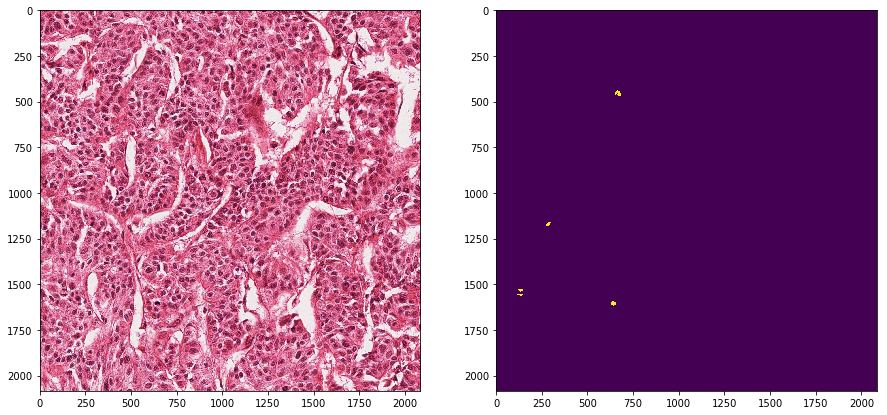

********************
(20, 2084, 2084, 3) (20, 2084, 2084, 1)


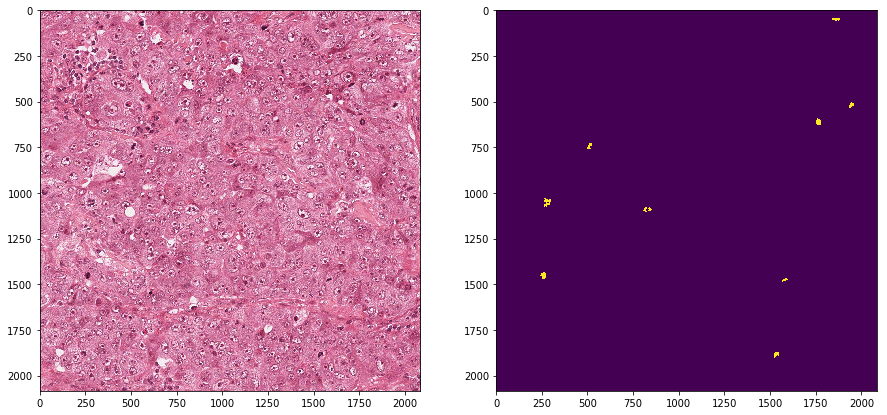

In [7]:
dg = dataGenerator(files_train, batches=20, weights=True)
for i in range(2):
    X, Y = next(dg)
    print(X.shape, Y.shape)
    preprocess.show_ndimg(X[0], Y[0])
    

In [8]:
model = get_model(n_kernels=1, img_height=2084, img_width=2084)
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2084, 2084, 3 0                                            
__________________________________________________________________________________________________
conv_1_1 (Conv2D)               (None, 2084, 2084, 1 28          input_1[0][0]                    
__________________________________________________________________________________________________
conv_2_2 (Conv2D)               (None, 2084, 2084, 1 10          conv_1_1[0][0]                   
__________________________________________________________________________________________________
pool_1 (MaxPooling2D)           (None, 1042, 1042, 1 0           conv_2_2[0][0]                   
__________________________________________________________________________________________________
conv2_1 (C

/home/matthias/projects/bio-unet/model_00.py:101: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input=inputs, output=conv10)


In [9]:
model.compile(loss="binary_crossentropy",
              optimizer=optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.98, nesterov=True),
              metrics=['accuracy'])
#K.get_session().run(tf.global_variables_initializer())
#tensorboard = TensorBoard(log_dir="logs") 
callbacks = [
             EarlyStopping(monitor='val_loss',
                           patience=2,
                           verbose=1),
             ModelCheckpoint("model01.h5",
                             monitor='val_loss',
                             save_best_only=True,
                             verbose=1)]
train_generator = dataGenerator(files_train, batches=10, weights=True)
valid_generator = dataGenerator(files_valid, batches=3, weights=True)

In [10]:
# batch_size determines the number of samples in each mini batch
# steps_per_epoch the number of batch iterations before a training epoch is considered finished.
# validation_steps
hist = model.fit_generator(generator=train_generator,
                    steps_per_epoch=1,
                    epochs=10,
                    verbose=2,
                    callbacks=callbacks,
                    validation_data=valid_generator,
                    validation_steps=1,
                    max_queue_size=2)

Epoch 1/10
****************************************

********************
********************
********************
********************
********************
********************
 - 43s - loss: 0.6886 - acc: 0.0000e+00 - val_loss: 0.6875 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 0.68752, saving model to model01.h5
Epoch 2/10
********************
********************
 - 33s - loss: 0.6875 - acc: 0.0000e+00 - val_loss: 0.6862 - val_acc: 0.0000e+00

Epoch 00002: val_loss improved from 0.68752 to 0.68621, saving model to model01.h5
Epoch 3/10
********************
********************
 - 33s - loss: 0.6862 - acc: 0.0000e+00 - val_loss: 0.6819 - val_acc: 0.0000e+00

Epoch 00003: val_loss improved from 0.68621 to 0.68191, saving model to model01.h5
Epoch 4/10
********************
********************
 - 36s - loss: 0.6819 - acc: 0.0000e+00 - val_loss: 0.6657 - val_acc: 0.0000e+00

Epoch 00004: val_loss improved from 0.68191 to 0.66570, saving model to model01.h5
Epoch 

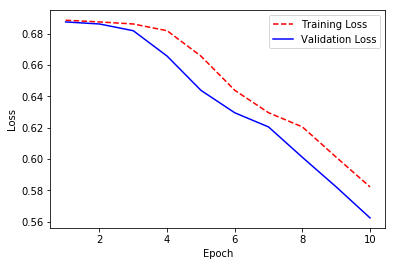

In [12]:
training_loss = hist.history['loss']
test_loss = hist.history['val_loss']

epoch_count = range(1, len(training_loss) + 1)

plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [13]:
with open(os.path.join(splitdata.d_data, splitdata.f_test), "rb") as file:
    files_test = pickle.load(file)
if not files_test:
    raise Exception("Could not load training files!")

In [14]:
X_test, Y_test = preprocess.load_data(files_test)

Loading data...
samples      8
Img size  (2084,2084)
size      1.11 GB
X.shape:  (8, 2084, 2084, 3)
Y.shape:  (8, 2084, 2084, 1)


In [15]:
X_test = X_test / 255

In [20]:
Y_pred = model.predict(X_test, batch_size=len(X_test), verbose=1)

8/8 [==============================] - 6s 757ms/step


In [21]:
print(Y_pred[0])

[[[ 0.42884329]
  [ 0.42884329]
  [ 0.42884329]
  ..., 
  [ 0.42884329]
  [ 0.42884329]
  [ 0.42884329]]

 [[ 0.42884329]
  [ 0.42884329]
  [ 0.42884329]
  ..., 
  [ 0.42884329]
  [ 0.42884329]
  [ 0.42884329]]

 [[ 0.42884329]
  [ 0.42884329]
  [ 0.42884329]
  ..., 
  [ 0.42884329]
  [ 0.42884329]
  [ 0.42884329]]

 ..., 
 [[ 0.42884329]
  [ 0.42884329]
  [ 0.42884329]
  ..., 
  [ 0.42884329]
  [ 0.42884329]
  [ 0.42884329]]

 [[ 0.42884329]
  [ 0.42884329]
  [ 0.42884329]
  ..., 
  [ 0.42884329]
  [ 0.42884329]
  [ 0.42884329]]

 [[ 0.42884329]
  [ 0.42884329]
  [ 0.42884329]
  ..., 
  [ 0.42884329]
  [ 0.42884329]
  [ 0.42884329]]]


In [17]:
Y_pred = np.around(Y_pred)

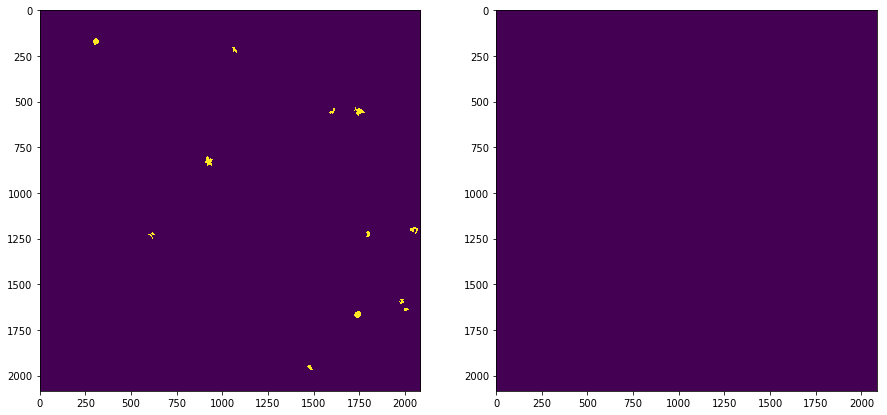

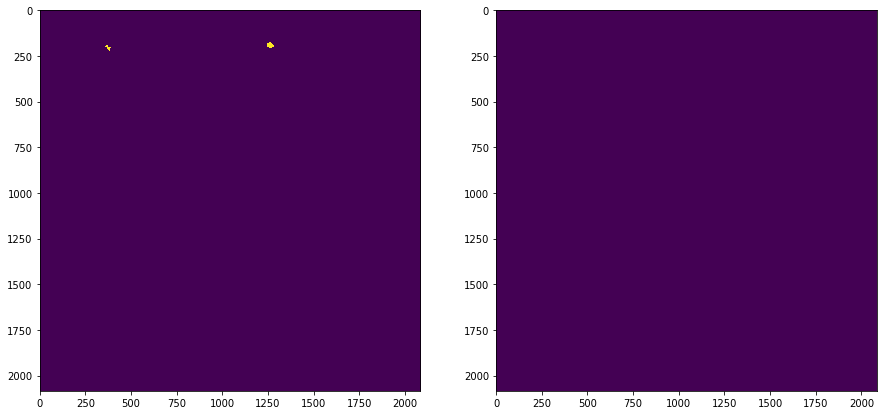

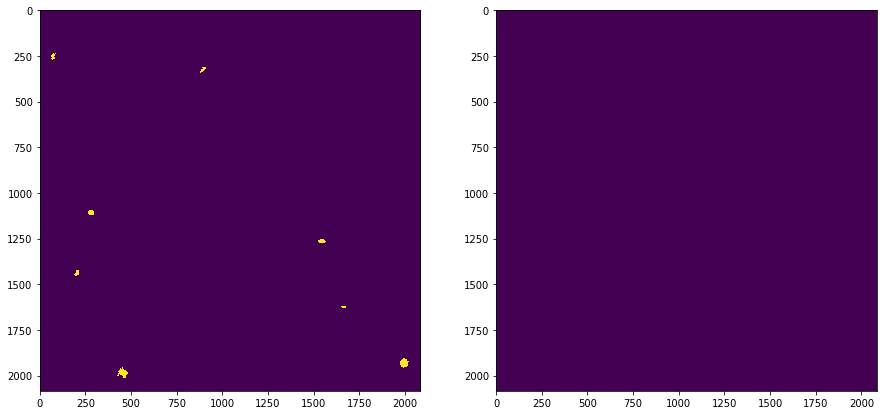

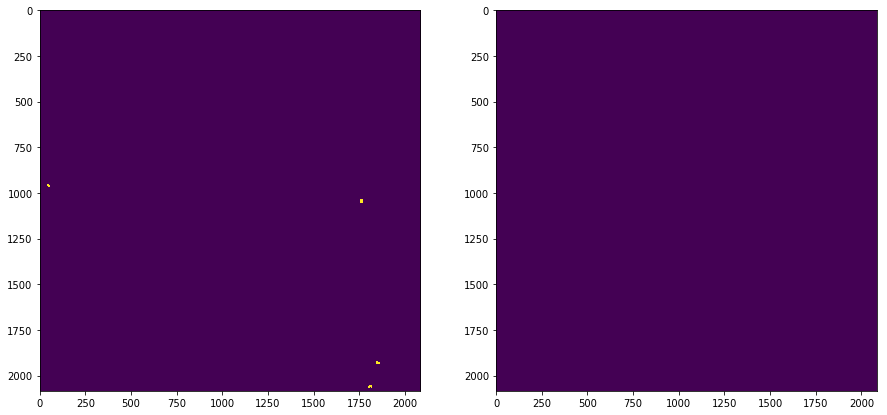

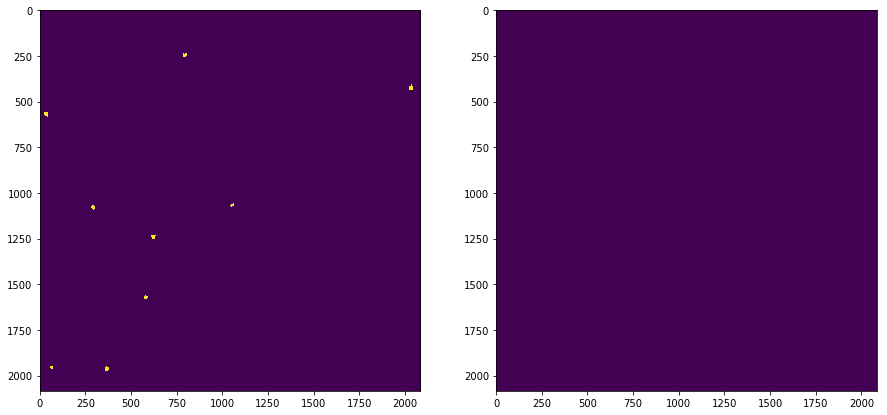

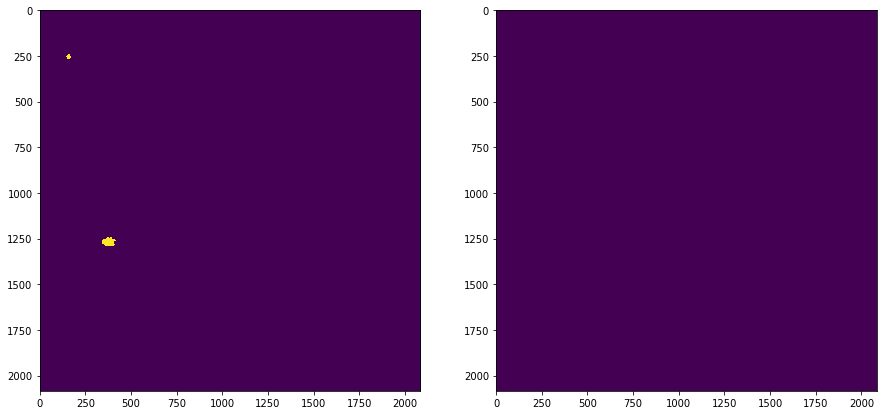

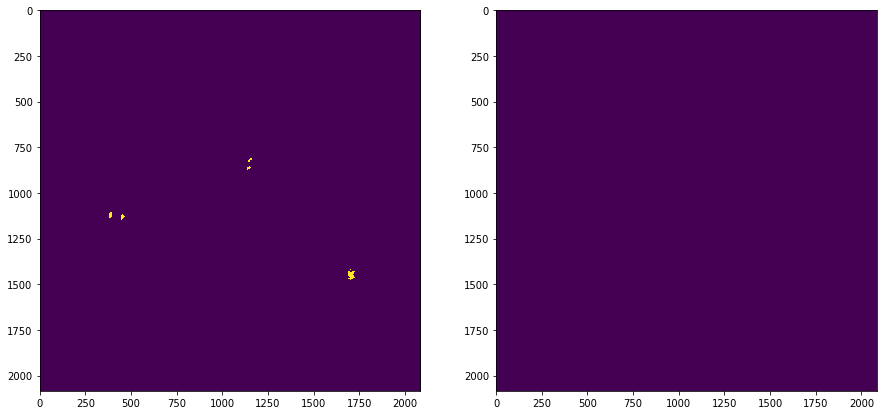

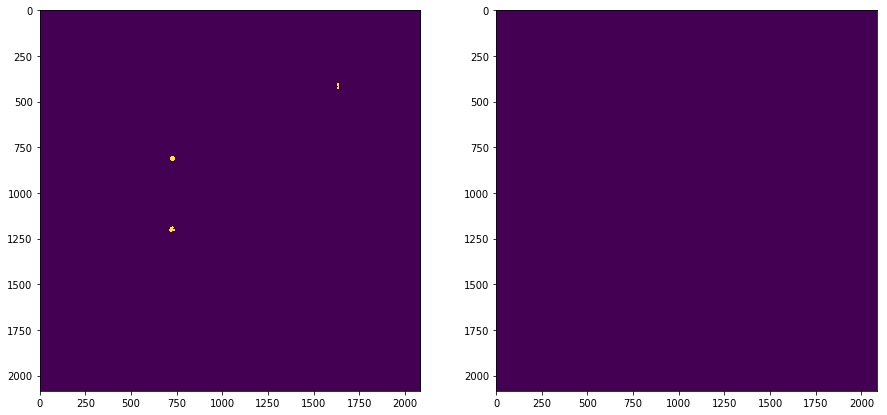

In [18]:
for i in range(Y_pred.shape[0]):
    preprocess.show_ndimg(Y_test[i], Y_pred[i])

In [19]:
for i in range(Y_pred.shape[0]):
    print(np.sum(Y_pred[i]))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
